In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torch import nn

from torch_geometric.loader import NeighborLoader
from torch_geometric.sampler import BaseSampler

from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

In [2]:
with open('C://Austin//Projects//MS_Thesis_Data//test_eye_clusters_extract.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [29]:
data.keys()

dict_keys(['name', 'image', 'features', 'factor', 'cluster', 'centroids'])

In [35]:
data["features"].shape

(127, 4096)

In [3]:
class Separated_Dataset(Dataset): #For this ds I have ald done all the required pre prcessing 
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_dict = None):
        self.data_dict = data_dict
        super().__init__(root, transform, pre_transform, pre_filter)
        
    @property
    def raw_file_names(self):
        return np.array([os.path.join(self.raw_dir, x) for x in self.data_dict["name"]])

    @property
    def processed_file_names(self):
        return "not_implemented.pt"
    
    def process(self):
        
        idx = -1

        # Process pre made data dictionary

        x_features = np.append(self.data_dict["features"], self.data_dict["centroids"], axis=0)
        x_features = torch.Tensor(x_features)
        y = np.append(self.data_dict["cluster"], np.array([127,128,129,130,131]), axis=0)
        
        edge_map = []


        i=-1
        for cluster in y[:127]:
            i+=1
            edge_map.append([np.int64(i), np.int64(cluster+self.data_dict["features"].shape[0])])
            #edge_map.append([np.int64(cluster+self.data_dict["features"].shape[0]), np.int64(i)])
        

        i+=1
        for centroid1 in y[i:-1]:
            for centroid2 in y[i+1:]:
                edge_map.append([np.int64(centroid1), np.int64(centroid2)])
                #edge_map.append([np.int64(centroid2+self.data_dict["features"].shape[0]), np.int64(centroid1+self.data_dict["features"].shape[0])])
            i+=1

        edge_attrs = [] 


        for edge in edge_map:
            edge_attrs.append(1)
        
        edge_attrs = np.array(edge_attrs)
        edge_attrs = np.delete(edge_attrs,1)
        edge_attrs = torch.Tensor(edge_attrs)

        edge_map_aux = [None,None]
        edge_map_aux[0] = [x[0] for x in edge_map]
        edge_map_aux[1] = [x[1] for x in edge_map]
        edge_map_aux = np.array(edge_map_aux)

        y = F.interpolate(torch.Tensor(self.data_dict["image"]).unsqueeze(0),(256,256,3))
        y = y.reshape(127,256,256,3)

        for i in range(self.data_dict["image"].shape[0]):
            
            
            y_temp = y[i]

            x_in_feat = torch.Tensor(self.data_dict["features"][i])


            edge_map_aux_temp = np.delete(edge_map_aux,i, axis = 1)


            data = Data({"graph":x_features, "features":x_in_feat}, torch.Tensor(edge_map_aux_temp).to(int), edge_attrs, y_temp)

            torch.save(data, os.path.join(self.processed_dir, f'data_{i}.pt'))

    def len(self):
        return self.data_dict["name"].shape[0]

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [4]:
root_path = "C://Austin//Projects//MS_Thesis_Data//base_gnn_testing_root//separated_training_set"
dataset = Separated_Dataset(root_path, data_dict=data)

Processing...
Done!


In [10]:
class Net(torch.nn.Module):
    def __init__(self, num_nodes, f_len):
        super().__init__()
        self.n = num_nodes
        self.f_len = f_len

        self.graph_enc_layer_1_1 = gnn.GraphConv(f_len, f_len)
        self.graph_enc_layer_1_2 = gnn.GraphConv(f_len, f_len)
        self.graph_enc_layer_2_1 = gnn.GraphConv(f_len, int(f_len/4))
        self.graph_enc_layer_2_2 = gnn.GraphConv(int(f_len/4), int(f_len/4))
        self.graph_enc_layer_3_1 = gnn.GraphConv(int(f_len/4), int(f_len/16))
        self.graph_enc_layer_3_2 = gnn.GraphConv(int(f_len/16), int(f_len/16))

        self.relu = nn.ReLU()
        self.conv_enc_pool = nn.MaxPool2d(2,2,0)
        
        self.conv_enc_1 = nn.Conv2d(1, int(self.n * 0.5), 3, 1, 1)
        self.conv_enc_2 = nn.Conv2d(int(self.n * 1.5), int(self.n*2), 3, 1, 1)
        self.conv_enc_3 = nn.Conv2d(int(self.n * 3), int(self.n*3.5), 3, 1, 1)
        self.conv_enc_4 = nn.Conv2d(int(self.n * 4.5), int(self.n*5), 3, 1, 1)

        self.conv_enc_4_1 = nn.Conv2d(int(self.n * 5), int(self.n*5), 3, 1, 1)

        self.conv_enc_4_2 = nn.Conv2d(int(self.n * 5), int(self.n*5), 3, 1, 1) # - Latent Space

        self.deconv_4 = nn.ConvTranspose2d(int(self.n*5),int(self.n * 4.5), 2,2,0)
        self.conv_dec_4 = nn.Conv2d(int(self.n * 9), int(self.n*4.5), 3, 1, 1)

        self.deconv_3 = nn.ConvTranspose2d(int(self.n * 4.5),int(self.n * 3), 2,2,0)
        self.conv_dec_3 = nn.Conv2d(int(self.n * 6), int(self.n*3), 3, 1, 1)

        self.deconv_2 = nn.ConvTranspose2d(int(self.n*3),int(self.n * 1.5), 2,2,0)
        self.conv_dec_2 = nn.Conv2d(int(self.n * 3), int(self.n*1.5), 3, 1, 1)

        self.deconv_1 = nn.ConvTranspose2d(int(self.n*1.5),int(self.n), 2,2,0)
        self.conv_dec_1 = nn.Conv2d(int(self.n), int(self.n*0.5), 3, 1, 1)

        self.deconv_out = nn.ConvTranspose2d(int(self.n*0.5),int(3), 2,2,0)



    def forward(self, nodes, edge_index, x, y=None):

        g = self.graph_enc_layer_1_1(nodes, edge_index)
        g = self.relu(g)
        g = self.graph_enc_layer_1_2(g, edge_index)
        g1 = g.reshape((int(self.n), 64, 64))
        g = self.relu(g)

        g = self.graph_enc_layer_2_1(g, edge_index)
        g = self.relu(g)
        g = self.graph_enc_layer_2_2(g, edge_index)
        g2 = g.reshape((int(self.n), 32, 32))
        g = self.relu(g)

        g = self.graph_enc_layer_3_1(g, edge_index)
        g = self.relu(g)
        g = self.graph_enc_layer_3_2(g, edge_index)
        g3 = g.reshape((int(self.n), 16, 16))

        x = self.conv_enc_1(x)
        x = self.relu(x)
        x1 = torch.cat((x,g1))
        x = self.conv_enc_pool(x1)

        x = self.conv_enc_2(x)
        x = self.relu(x)
        x2 = torch.cat((x,g2))
        x = self.conv_enc_pool(x2)

        x = self.conv_enc_3(x)
        x = self.relu(x)
        x3 = torch.cat((x,g3))
        x = self.conv_enc_pool(x3)

        x = self.conv_enc_4(x)
        x = self.relu(x)
        x4 = x

        x = self.conv_enc_4_1(x)
        x = self.conv_enc_4_2(x)

        x = self.deconv_4(x)
        x = torch.cat((x,x3))
        x = self.conv_dec_4(x)

        x = self.deconv_3(x)
        x = torch.cat((x,x2))
        x = self.conv_dec_3(x)
        
        x = self.deconv_2(x)
        x = torch.cat((x,x1))
        x = self.conv_dec_2(x)

        x = self.deconv_1(x)
        x = self.conv_dec_1(x)
        x = self.deconv_out(x)
        
        return x

In [11]:
model = Net(132, 4096).to("cpu")
print(model)

Net(
  (graph_enc_layer_1_1): GraphConv(4096, 4096)
  (graph_enc_layer_1_2): GraphConv(4096, 4096)
  (graph_enc_layer_2_1): GraphConv(4096, 1024)
  (graph_enc_layer_2_2): GraphConv(1024, 1024)
  (graph_enc_layer_3_1): GraphConv(1024, 256)
  (graph_enc_layer_3_2): GraphConv(256, 256)
  (relu): ReLU()
  (conv_enc_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_enc_1): Conv2d(1, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_2): Conv2d(198, 264, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_3): Conv2d(396, 462, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_4): Conv2d(594, 660, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_4_1): Conv2d(660, 660, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_4_2): Conv2d(660, 660, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv_4): ConvTranspose2d(660, 594, kernel_size=(2, 2), stride=(2, 2))
  (conv_dec_4): Conv2d(11

In [35]:
dataset[0].x["graph"].shape

torch.Size([132, 4096])

In [37]:
dataset[0].y.shape

torch.Size([256, 256, 3])

In [38]:
out = model.forward(dataset[0].x["graph"], dataset[0].edge_index, dataset[0].x["features"].reshape(1,64,64))
out.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3724136..1.8517468].


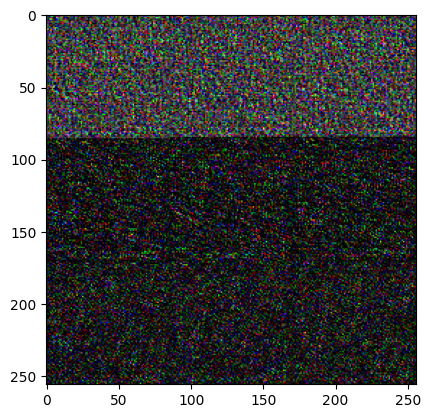

In [13]:
plt.imshow(out.reshape(256,256,3).detach().numpy())
plt.show()

In [58]:
model = Net(132, 4096).to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss = nn.MSELoss()
epochs = 1000
best = [0, np.Inf]

In [ ]:
#Training loop for model
def train_step(model, optimizer, x, edge_index, y, loss_func=nn.CrossEntropyLoss()):

    #Training loop step as defined for Pytorch models
    optimizer.zero_grad()

    pred = model.forward(x["graph"], edge_index, x["features"].reshape(1,64,64))
    pred = pred.reshape(256,256,3)
    #del x
    loss = loss_func(pred, y)
    #del y
    loss.backward()
    optimizer.step()

    return float(loss.detach())



loss_dict = {"train":[], "valid":[]}

for epoch in range(epochs):

        model.train(True)

        #Set up mini batches as slices of dataset
        #ind = np.array([i for i in range(b["x"].shape[0])])
        #np.random.shuffle(ind)
        run_loss = 0.0

        #x_batch = x_batch.to("cuda")
        #y_batch = y_batch.to("cuda")
        for sample in range(len(dataset)):
          run_loss += train_step(model, optimizer, dataset[sample].x, dataset[sample].edge_index, dataset[sample].y, loss)

        loss_dict["train"].append(np.round(run_loss/len(dataset)))

        #Epoch level evaluation
        """
        model.eval()
        with torch.no_grad():
            run_val_loss = 0.0
            f1_avg = 0.0

            for slice in ind.reshape([15,200]):
              xv_batch = v["x"][slice]
              yv_batch = v["y"][slice]

              xv_batch = xv_batch.to("cuda")
              yv_batch = yv_batch.to("cuda")

              valid = model.forward(xv_batch)

              del xv_batch

              val_acc = loss(valid, yv_batch)
              run_val_loss += float(val_acc.detach())

              f1 = metrics.MulticlassF1Score()
              f1.update(valid, yv_batch)

              del yv_batch

              f1_score = f1.compute()
              f1_avg += f1_score


            loss_dict["valid"].append(np.round(run_val_loss/15,3))
            f1_score  = f1_avg/15
          """

        print(str(epoch), " - Avg train loss:", str(np.round(run_loss/len(dataset))))

        if best[1] > run_loss:
          best[1] = run_loss
          best[0] = epoch
          torch.save(model.state_dict(), "C://Austin//Projects//MS_Thesis//tester_code_files//tester_models//init_unet.pickle")



0  - Avg train loss: 1257011030.0
1  - Avg train loss: 15694.0
2  - Avg train loss: 10400.0
3  - Avg train loss: 8011.0
4  - Avg train loss: 6965.0
5  - Avg train loss: 6293.0
6  - Avg train loss: 5974.0
7  - Avg train loss: 5662.0
8  - Avg train loss: 5481.0
9  - Avg train loss: 5343.0
10  - Avg train loss: 5204.0
11  - Avg train loss: 5103.0
12  - Avg train loss: 5027.0
